In [1]:
!unzip Dataset.zip

Archive:  Dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
note:  Dataset.zip may be a plain executable, not an archive
unzip:  cannot find zipfile directory in one of Dataset.zip or
        Dataset.zip.zip, and cannot find Dataset.zip.ZIP, period.


# DeepFake Detection App with CNN Using a ResNet-18 Based Approach

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
from typing import Type
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve,classification_report,precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time  

In [3]:
class BasicBlock(nn.Module):
    """
    Builds the Basic Block of the ResNet model.
    For ResNet18 and ResNet34, these are stackings od 3x3=>3x3 convolutional
    layers.
    For ResNet50 and above, these are stackings of 1x1=>3x3=>1x1 (BottleNeck) 
    layers.
    """
    def __init__(
        self, 
        num_layers: int,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        self.num_layers = num_layers
        # Multiplicative factor for the subsequent conv2d layer's output 
        # channels.
        # It is 1 for ResNet18 and ResNet34, and 4 for the others.
        self.expansion = expansion
        self.downsample = downsample
        # 1x1 convolution for ResNet50 and above.
        if num_layers > 34:
            self.conv0 = nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=1, 
                stride=1,
                bias=False
            )
            self.bn0 = nn.BatchNorm2d(out_channels)
            in_channels = out_channels
        # Common 3x3 convolution for all.
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 1x1 convolution for ResNet50 and above.
        if num_layers > 34:
            self.conv2 = nn.Conv2d(
                out_channels, 
                out_channels*self.expansion, 
                kernel_size=1, 
                stride=1,
                bias=False
            )
            self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        else:
            # 3x3 convolution for ResNet18 and ResNet34 and above.
            self.conv2 = nn.Conv2d(
                out_channels, 
                out_channels*self.expansion, 
                kernel_size=3, 
                padding=1,
                bias=False
            )
            self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
    
        # Through 1x1 convolution if ResNet50 or above.
        if self.num_layers > 34:
            out = self.conv0(x)
            out = self.bn0(out)
            out = self.relu(out)
        # Use the above output if ResNet50 and above.
        if self.num_layers > 34:
            out = self.conv1(out)
        # Else use the input to the `forward` method.
        else:
            out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

In [4]:


class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        if num_layers == 34:
            layers = [3, 4, 6, 3]
            self.expansion = 1
        if num_layers == 50:
            layers = [3, 4, 6, 3]
            self.expansion = 4
        if num_layers == 101:
            layers = [3, 4, 23, 3]
            self.expansion = 4
        if num_layers == 152:
            layers = [3, 8, 36, 3]
            self.expansion = 4
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], num_layers=num_layers)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, num_layers=num_layers)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, num_layers=num_layers)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, num_layers=num_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1,
        num_layers: int = 18
    ) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.in_channels != out_channels * self.expansion:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                num_layers, 
                self.in_channels, 
                out_channels, 
                stride, 
                self.expansion, 
                downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                num_layers,
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Dataset/Train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='Dataset/Test', transform=transform_test)

# Split the training dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True,num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=10)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False,num_workers=10)

# Define ResNet model (you'll need to implement ResNet or import it)
model = ResNet(img_channels=3, num_layers=50, block=BasicBlock, num_classes=2).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and validation loop
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch
    
    # Training phase
    print(f"Training ..... Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Append training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Append validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculate epoch duration and print it in minutes and seconds
    epoch_duration = time.time() - epoch_start_time
    minutes, seconds = divmod(epoch_duration, 60)
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - '
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}% - '
        f'Time: {int(minutes)} min {int(seconds)} sec')

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")



print("=================DONE=================")



Training ..... Epoch 1/10
Epoch [1/10] - Train Loss: 0.5827, Train Accuracy: 69.13% - Val Loss: 0.4046, Val Accuracy: 87.01% - Time: 11 min 25 sec
Model saved!
Training ..... Epoch 2/10
Epoch [2/10] - Train Loss: 0.3383, Train Accuracy: 91.35% - Val Loss: 0.3208, Val Accuracy: 92.02% - Time: 10 min 56 sec
Model saved!
Training ..... Epoch 3/10
Epoch [3/10] - Train Loss: 0.3011, Train Accuracy: 93.77% - Val Loss: 0.2868, Val Accuracy: 94.66% - Time: 10 min 56 sec
Model saved!
Training ..... Epoch 4/10
Epoch [4/10] - Train Loss: 0.2832, Train Accuracy: 94.92% - Val Loss: 0.2712, Val Accuracy: 95.71% - Time: 10 min 56 sec
Model saved!
Training ..... Epoch 5/10
Epoch [5/10] - Train Loss: 0.2719, Train Accuracy: 95.56% - Val Loss: 0.2826, Val Accuracy: 94.81% - Time: 10 min 56 sec
Training ..... Epoch 6/10
Epoch [6/10] - Train Loss: 0.2625, Train Accuracy: 96.10% - Val Loss: 0.2699, Val Accuracy: 95.68% - Time: 10 min 56 sec
Model saved!
Training ..... Epoch 7/10
Epoch [7/10] - Train Loss: 

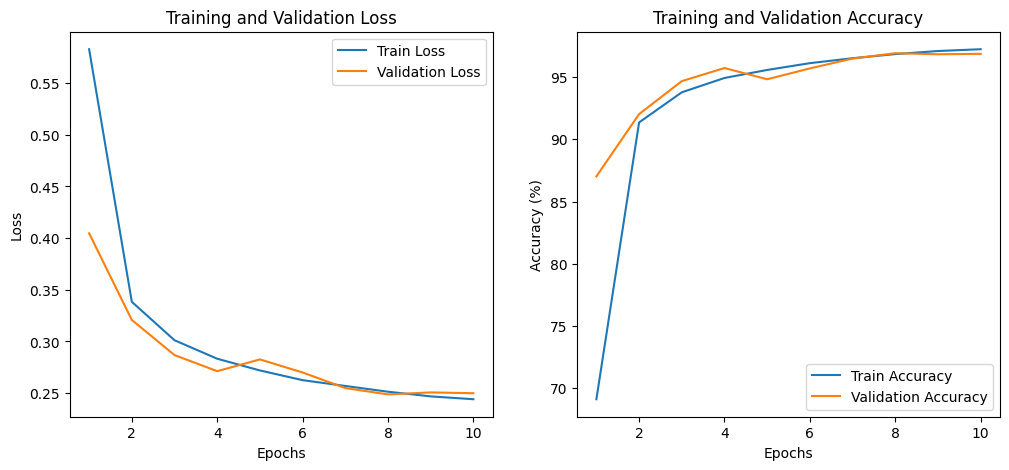

In [7]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store predictions and true labels
            pred_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return true_labels, pred_labels

In [9]:
true_labels, pred_labels = evaluate_model(model, test_loader,device=device)

In [10]:
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9392
Precision: 0.9490
Recall: 0.9274
F1 Score: 0.9381


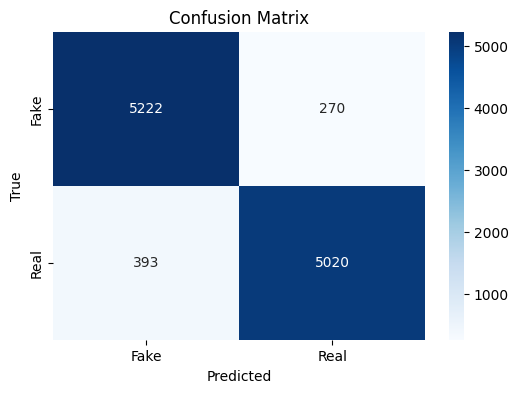

In [11]:

plt.figure(figsize=(6, 4))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.95      0.94      5492
        Real       0.95      0.93      0.94      5413

    accuracy                           0.94     10905
   macro avg       0.94      0.94      0.94     10905
weighted avg       0.94      0.94      0.94     10905



AUC Score: 0.94


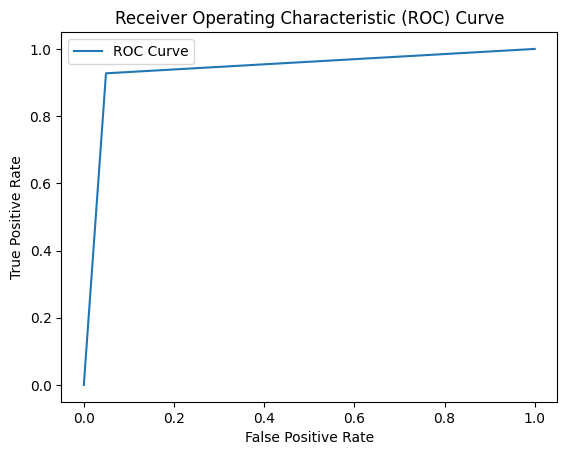

In [13]:
auc_score = roc_auc_score(true_labels, pred_labels)
print(f"AUC Score: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


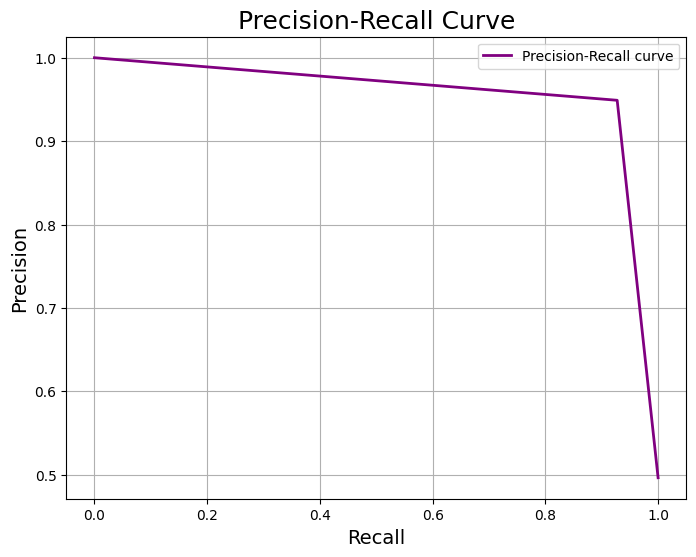

In [14]:
precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=18)
plt.legend(loc="best")
plt.grid(True)
plt.show()

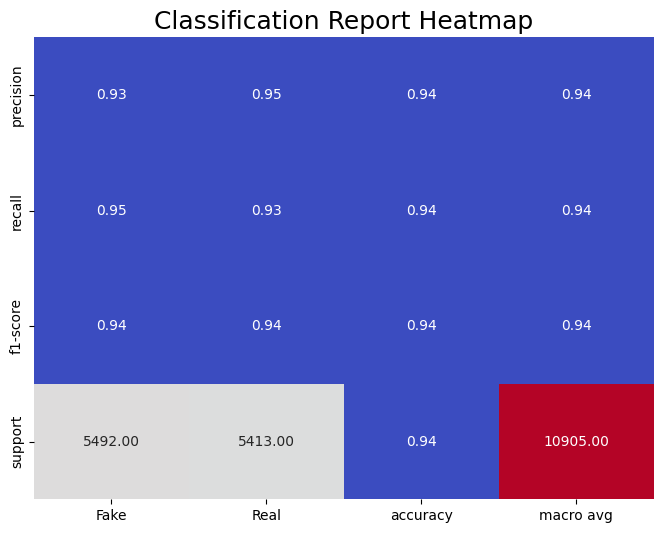

In [15]:
report_dict = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'], output_dict=True)

# Convert to DataFrame for easier visualization
report_df = pd.DataFrame(report_dict).transpose()

# Plot the classification report as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f")
plt.title('Classification Report Heatmap', fontsize=18)
plt.show()

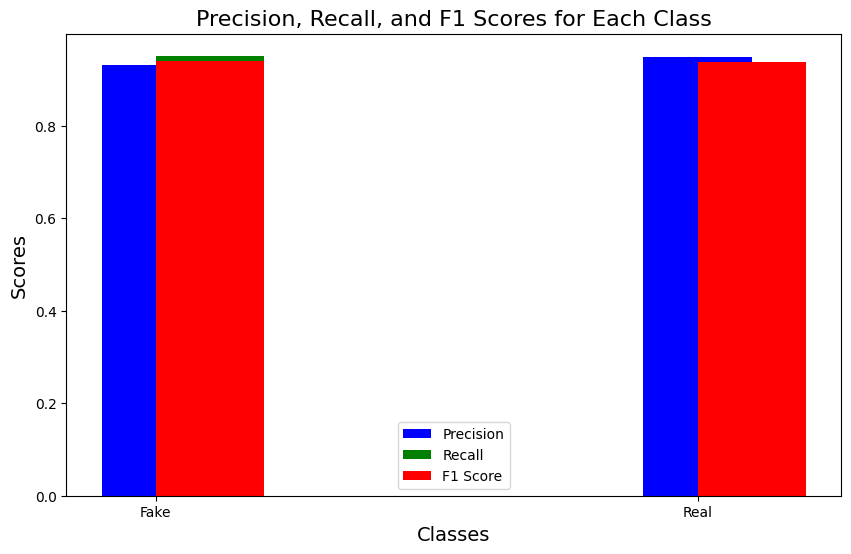

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Get precision, recall, f1-score for each class
precision_fake = precision_score(true_labels, pred_labels, pos_label=0)
precision_real = precision_score(true_labels, pred_labels, pos_label=1)

recall_fake = recall_score(true_labels, pred_labels, pos_label=0)
recall_real = recall_score(true_labels, pred_labels, pos_label=1)

f1_fake = f1_score(true_labels, pred_labels, pos_label=0)
f1_real = f1_score(true_labels, pred_labels, pos_label=1)

# Bar chart for precision, recall, and F1
labels = ['Fake', 'Real']
precision = [precision_fake, precision_real]
recall = [recall_fake, recall_real]
f1_scores = [f1_fake, f1_real]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', color='b', align='center')
plt.bar(x, recall, width=0.2, label='Recall', color='g', align='edge')
plt.bar(x, f1_scores, width=0.2, label='F1 Score', color='r', align='edge')

plt.xticks(x, labels)
plt.title('Precision, Recall, and F1 Scores for Each Class', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(loc='best')
plt.show()
